In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal

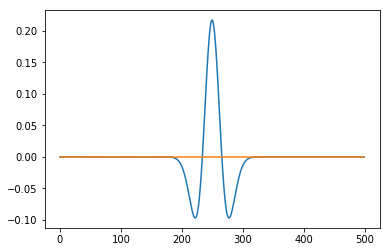

In [2]:
t1 = signal.ricker(500, 16.0)
# t1 = np.imag(signal.hilbert(signal.ricker(100, 4.0)))
t2 = np.zeros(t1.shape)
plt.plot(t1)
plt.plot(t2)

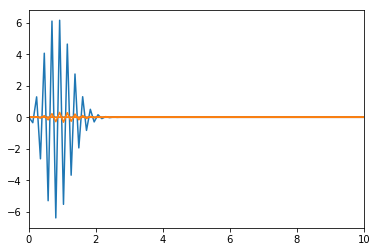

In [3]:

sp = np.fft.fft(t1)
freq = np.rad2deg(np.fft.fftfreq(t1.shape[-1]))
plt.plot(freq, sp.real, freq, sp.imag)
plt.xlim(0,10)
plt.show()

In [4]:



def _shift(pair,shift):
    """shift t1 shift/2 samples to the left and
       shift t2 shift/2 samples to the right,
       if shift is odd move t1 the extra sample
       this process truncates trace length"""
    if shift == 0:
        return pair
    elif shift == 1:
        t1 = pair[0,:]
        t2 = pair[1,:]
        return np.vstack((t1[math.ceil(shift/2):], t2[:-shift]))
    else:
        t1 = pair[0,:]
        t2 = pair[1,:]
        return np.vstack((t1[math.ceil(shift/2):-math.floor(shift/2)], t2[:-shift]))

def _rotate(pair,degrees):
    """t1 is x-axis and t2 is y-axis,
       rotates clockwise"""
    ang = np.deg2rad(degrees)
    rot = np.array([[np.cos(ang),-np.sin(ang)],
                    [np.sin(ang), np.cos(ang)]])
    return np.dot(rot,pair)

def _rotate_and_shift(pair,degrees,shift):
    return _shift(_rotate(pair,degrees), shift)

def _split(pair,degrees,shift):
    return _rotate(_shift(_rotate(pair,degrees), shift),-degrees)

def _unsplit(pair,degrees,shift):
    return _split(pair,degrees+90,shift)
    
def _taper(pair,width,centre=None):
    """Apply Hanning window about c0 sample
       of width number of samples, truncates traces"""
    
    if centre is None:
        centre = math.floor(pair.shape[1]/2)
        
    if width > pair.shape[1]:
        raise Exception('taper width is greater than trace length')
        
    t0 = centre - math.floor(width/2)
    t1 = centre + math.ceil(width/2)
    
    if t0 < 0:
        raise Exception('window starts before trace data')
    elif t1 > pair.shape[1]:
        raise Exception('window ends after trace data')
        
    return np.hanning(width) * pair[:,t0:t1]

def _eigcov(pair):
    return np.sort(np.linalg.eigvals(np.cov(pair,rowvar=True)))
#     return np.sort(np.linalg.eigvals(np.cov(pair)))

def _grideigcov(pair,maxshift,window=None, stepang=None,stepshift=None):
    
    # set some defaults
    if stepshift is None:
        stepshift = int(np.max([1,maxshift/40]))
    if stepang is None:
        stepang = 2
    if window is None:
        # by default whatevers smaller,
        # half trace length or 10 * max shift
        window = int(np.min([pair.shape[1] * 0.5,maxshift * 10]))
    
    deg, shift = np.meshgrid(np.arange(0,180,stepang),
                             np.arange(0,maxshift,stepshift).astype(int))
    
    shape = deg.shape
    lam1 = np.zeros(shape)
    lam2 = np.zeros(shape)
    for ii in np.arange(shape[1]):
        temp = _rotate(pair,deg[0,ii]+90)
        for jj in np.arange(shape[0]):
            temp2 = _shift(temp,shift[jj,ii])
            temp3 = _taper(temp2,window)
            lam2[jj,ii], lam1[jj,ii] = _eigcov(temp3)
    return deg, shift, lam1, lam2

def _xcorr(pair):
    return np.correlate(pair[0,:],pair[1,:])[0]

def _gridxcorr(pair,maxshift,window=None, stepang=None,stepshift=None):
    
    # set some defaults
    if stepshift is None:
        stepshift = int(np.max([1,maxshift/40]))
    if stepang is None:
        stepang = 2
    if window is None:
        # by default whatevers smaller,
        # half trace length or 10 * max shift
        window = int(np.min([pair.shape[1] * 0.5,maxshift * 10]))
        
    deg, shift = np.meshgrid(np.arange(0,180,stepang),
                             np.arange(0,maxshift,stepshift).astype(int))
    
    shape = deg.shape
    xc = np.zeros(shape)
    for ii in np.arange(shape[1]):
        temp = _rotate(pair,deg[0,ii]+90)
        for jj in np.arange(shape[0]):
            temp2 = _shift(temp,shift[jj,ii])
            temp3 = _taper(temp2,window)
            xc[jj,ii] = _xcorr(temp3)
    return deg, shift, xc  

In [5]:
pair = np.vstack((t1,t2))
a = _shift(pair,5)
# b = _rotate(pair,45)
# c = _rotate_and_shift(pair,30,10)
plt_pair(a)

NameError: name 'plt_pair' is not defined

In [ ]:
def plt_wigg(pair):
    plt.plot(pair.T)
    plt.show()
    
def plt_hodo(pair):
    plt.plot(pair[0,:],pair[1,:])
    plt.show()

def plt_pair(pair):
    from matplotlib import gridspec
    fig = plt.figure(figsize=(12, 6)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
    ax0 = plt.subplot(gs[0])
    ax0.plot(pair.T)
    ax1 = plt.subplot(gs[1])
    ax1.plot(pair[0,:],pair[1,:])
    plt.axis('equal')
    plt.show()
    
def plt_surf(surf):
    from matplotlib import colors, ticker, cm
    plt.contourf(shift,deg,l2/(l1+l2),locator=ticker.LogLocator(),cmap='viridis_r')

In [6]:

splitdata = _split(pair,110,12)
# unsplitdata = _unsplit(splitdata,15,20)
plt_pair(splitdata)
deg,shift,l1,l2 = _grideigcov(splitdata,25)
plt.contourf(shift,deg,l2/(l1+l2),locator=ticker.LogLocator(),cmap='viridis_r')

NameError: name 'plt_pair' is not defined

In [7]:
from matplotlib import colors, ticker, cm
splitdata = _split(pair,110,12)
# unsplitdata = _unsplit(splitdata,15,20)
plt_pair(splitdata)
deg,shift,xc = _gridxcorr(splitdata,25)
plt.contourf(shift,deg,xc,cmap='viridis')

NameError: name 'plt_pair' is not defined

In [8]:
xc.max()
np.argmax(xc)

NameError: name 'xc' is not defined

In [9]:
data1 = _taper(splitdata,30)
data2 = _taper(_shift(splitdata,1),30)


In [10]:
print(np.correlate(data1[0,:],data1[1,:]))
print(np.correlate(data2[0,:],data2[1,:]))

[ 0.01427939]
[ 0.02136148]


In [11]:
print(np.correlate(data1[0,:],data1[1,:],'same'))

[-0.00234573 -0.00330796 -0.00441404 -0.00559636 -0.00675517 -0.00776247
 -0.00847046 -0.00872404 -0.00837662 -0.00730737 -0.00543819 -0.00274811
  0.00071701  0.00484095  0.00944102  0.01427939  0.0190813   0.02355906
  0.02743941  0.03048987  0.03254015  0.03349646  0.03334748  0.03216166
  0.03007669  0.02728281  0.02400202  0.02046612  0.01689566  0.01348245]


In [12]:
x = np.correlate(data1[0,:],data1[1,:],'same')

In [13]:
x[15]

0.014279386171869884